# Pre-Comparison

In [2]:
# Libraries (Venn Diagram)
library(tidyverse)
library(VennDiagram)

# Libraries (NMDS)
library(ROBITools)
library(reshape2)
library(vegan)
library(ggalt)
library(ggpubr)
library(ggrepel)

In [3]:
newnames <- c('EN0.2A','EN0.2B','EN0.2C','OP0.2A','OP0.2B','OP0.2C','OP1.2A','OP1.2B','OP1.2C','OP5.0A','OP5.0B','OP5.0C','OP8.0A','OP8.0B','OP8.0C')

### Metabarcoding

In [4]:
# Data
metabar_taxa  <- read.delim("GenomeDK_Metabar/classified.txt")
metabar_count <- read.delim("GenomeDK_Metabar/DADA2_nochim.table")

In [5]:
# Select controls
m_cne <- grepl("CNE", names(metabar_count))
m_cne[1] <- TRUE
m_ntc <- grepl("NTC", names(metabar_count))
m_ntc[1] <- TRUE

cne <- metabar_count[,m_cne]
ntc <- metabar_count[,m_ntc]

# Find contaminants
cne_cont <- cne %>% mutate(total = rowSums(cne[,-1])) %>% filter(total > 0)
ntc_cont <- ntc %>% mutate(total = rowSums(ntc[,-1])) %>% filter(total > 0)

In [6]:
# Select contaminant sequences
cont <- unique(c(cne_cont$id, ntc_cont$id))

# Remove contaminants and filter
metabarcoding <- metabar_taxa %>% filter(!qseqid %in% cont) %>% filter(pident.max.best > 90)

# Select contaminants
contaminants <- metabar_taxa %>% filter(qseqid %in% cont)

# Metabarcoding diversity
tx <- metabarcoding[,c(8:14)]
dk <- length(unique(tx$kingdom[!is.na(tx$kingdom)]))
dp <- length(unique(tx$phylum[!is.na(tx$phylum)]))
dc <- length(unique(tx$class[!is.na(tx$class)]))
do <- length(unique(tx$order[!is.na(tx$order)]))
df <- length(unique(tx$family[!is.na(tx$family)]))
dg <- length(unique(tx$genus[!is.na(tx$genus)]))
ds <- length(unique(tx$species[!is.na(tx$species)]))

message(paste("Metabarcoding diversity: kingdom: ", dk, ", phylum: ", dp,
              ", class: ", dc, ", order: ", do, ", family: ", df, ", genus: ", dg, " and species: ", ds, sep=""))

Metabarcoding diversity: kingdom: 3, phylum: 46, class: 155, order: 432, family: 808, genus: 1292 and species: 2058



In [7]:
# Remove contaminant from counts
metabar_count_clean <- metabar_count %>% filter(!id %in% cont)
metabar_count_clean <- metabar_count_clean[,!grepl("NTC", names(metabar_count_clean))]
metabar_count_clean <- metabar_count_clean[,!grepl("CNE", names(metabar_count_clean))]

In [8]:
# Rename columns
cols <- colnames(metabar_count_clean)

clean_cols <- str_replace(str_replace(cols[-1], "sample.", ""),"u","")
clean_cols <- str_replace(clean_cols, "GP1", "EN0.2A")
clean_cols <- str_replace(clean_cols, "GP2", "EN0.2B")
clean_cols <- str_replace(clean_cols, "GP3", "EN0.2C")
clean_cols <- str_replace(clean_cols, "1_0.2", "OP0.2A")
clean_cols <- str_replace(clean_cols, "2_0.2", "OP0.2B")
clean_cols <- str_replace(clean_cols, "3_0.2", "OP0.2C")
clean_cols <- str_replace(clean_cols, "1_1.2", "OP1.2A")
clean_cols <- str_replace(clean_cols, "2_1.2", "OP1.2B")
clean_cols <- str_replace(clean_cols, "3_1.2", "OP1.2C")
clean_cols <- str_replace(clean_cols, "1_5.0", "OP5.0A")
clean_cols <- str_replace(clean_cols, "2_5.0", "OP5.0B")
clean_cols <- str_replace(clean_cols, "3_5.0", "OP5.0C")
clean_cols <- str_replace(clean_cols, "1_8.0", "OP8.0A")
clean_cols <- str_replace(clean_cols, "2_8.0", "OP8.0B")
clean_cols <- str_replace(clean_cols, "3_8.0", "OP8.0C")

colnames(metabar_count_clean)[-1] <-  clean_cols
cols <- colnames(metabar_count_clean)

**Rarefaction**

In [9]:
# Save dataset for ROBITools
cs2mr <- metabar_count_clean
colnames(cs2mr)[-1] <- paste("sample:", colnames(cs2mr)[-1], sep="")
f = 'GenomeDK_Metabar/temporal/all_for_rep_rarefy.txt'
write.table(cs2mr, file=f, quote=FALSE, sep='\t', col.names = NA, row.names=TRUE)

In [10]:
# Load dataset into ROBITools
dfimp <- import.metabarcoding.data(f)
df_mod <- dfimp$samples %>% mutate(replicate =  dfimp$samples$sample) %>% mutate(sample = gsub("_[0-9]", "", dfimp$samples$sample))
dfimp@samples = df_mod

In [11]:
# Rarefy metabarcoding
median = median(rowSums(dfimp$reads[dfimp$samples$replicate,]))
raw.rarefy = ROBITools::rarefy(dfimp, n=median, MARGIN='sample')
tmp = ROBITools:::aggregate.metabarcoding.data(raw.rarefy, by=list(sample=raw.rarefy$samples$sample), FUN=sum)
minimum = min(rowSums(tmp$reads[tmp$samples$sample,]))
final.rarefy = ROBITools::rarefy(tmp, n=minimum, MARGIN = 'sample')

### Shotgun

In [15]:
# Datasets
shotgun_taxa_count <- read.delim("GenomeDK_LCA/counts.lca.rarefy.tsv")
shotgun_eu <- shotgun_taxa_count %>% filter(superkingdom == "Eukaryota")

# Comparison

In [12]:
# Function
display_venn <- function(x, ...){
  grid.newpage()
  venn_object <- venn.diagram(x, filename = NULL, ...)
  grid.draw(venn_object)
}

In [13]:
# Clean rarefied metabarcoding
remove <- colnames(final.rarefy@reads)[colSums(final.rarefy@reads) == 0]
metbar <- metabarcoding[!metabarcoding$qseqid %in% remove,]

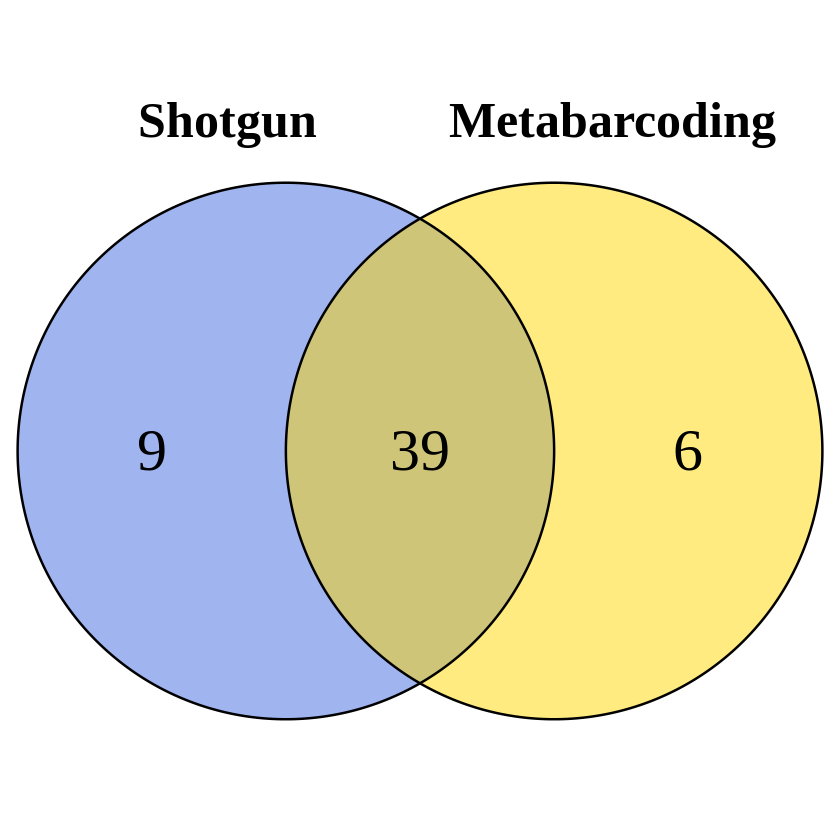

In [16]:
# Phylum
phyl_metabar <- unique(metbar$phylum[!is.na(metbar$phylum)])
phyl_shotgun <- unique(shotgun_eu$phylum[!is.na(shotgun_eu$phylum)])
taxa <- list(metabarcoding = phyl_metabar, shotgun_eu = phyl_shotgun)

# Venn Diagram (Saved manually)
display_venn(taxa,
             category.names = c("Metabarcoding", "Shotgun"),
             fill = c("gold", "royalblue"),
             cex = 3,
             cat.cex = 2.5, cat.fontface = "bold", 
             cat.pos = c(10,-10),
             cat.dist = c(0.05, 0.05),
             scaled = F)

In [17]:
table(taxa$metabarcoding %in% taxa$shotgun_eu)
table(taxa$shotgun_eu %in% taxa$metabarcoding)


FALSE  TRUE 
    6    39 


FALSE  TRUE 
    9    39 

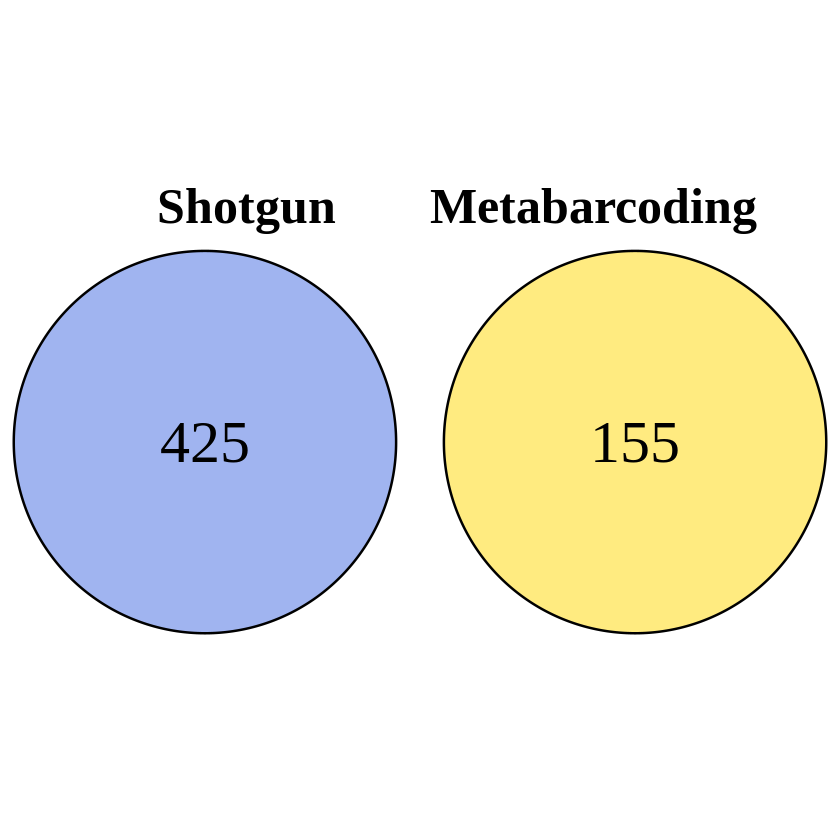

In [18]:
# Class
cla_metabar <- unique(metbar$class[!is.na(metbar$class)])
cla_shotgun <- unique(shotgun_eu$class[!is.na(shotgun_eu$class)])
taxa <- list(metabarcoding = cla_metabar, shotgun_eu = cla_shotgun)

# Venn Diagram (Saved manually)
display_venn(taxa,
             category.names = c("Metabarcoding", "Shotgun"),
             fill = c("gold", "royalblue"),
             cex = 3,
             cat.cex = 2.5, cat.fontface = "bold",
             cat.pos = c(-10,10),
             cat.dist = c(0.05, 0.05),
             scaled = F)

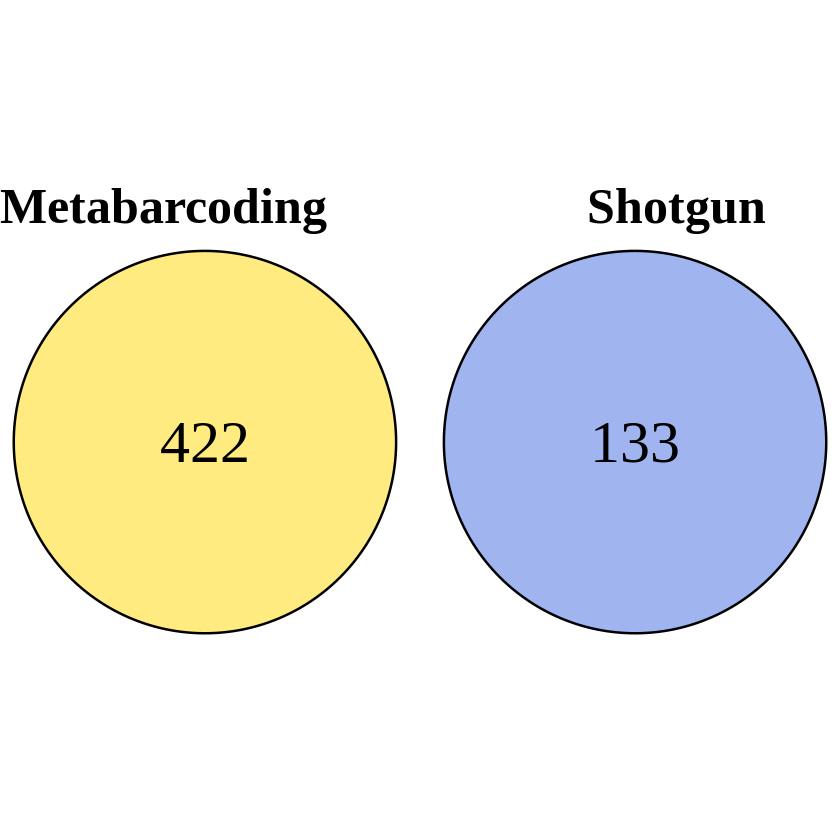

In [19]:
# Order
ord_metabar <- unique(metbar$order[!is.na(metbar$order)])
ord_shotgun <- unique(shotgun_eu$order[!is.na(shotgun_eu$order)])
taxa <- list(metabarcoding = ord_metabar, shotgun_eu = ord_shotgun)

# Venn Diagram (Saved manually)
display_venn(taxa,
             category.names = c("Metabarcoding", "Shotgun"),
             fill = c("gold", "royalblue"),
             cex = 3,
             cat.cex = 2.5, cat.fontface = "bold",
             cat.pos = c(-10,10),
             cat.dist = c(0.05, 0.05),
             scaled = F)

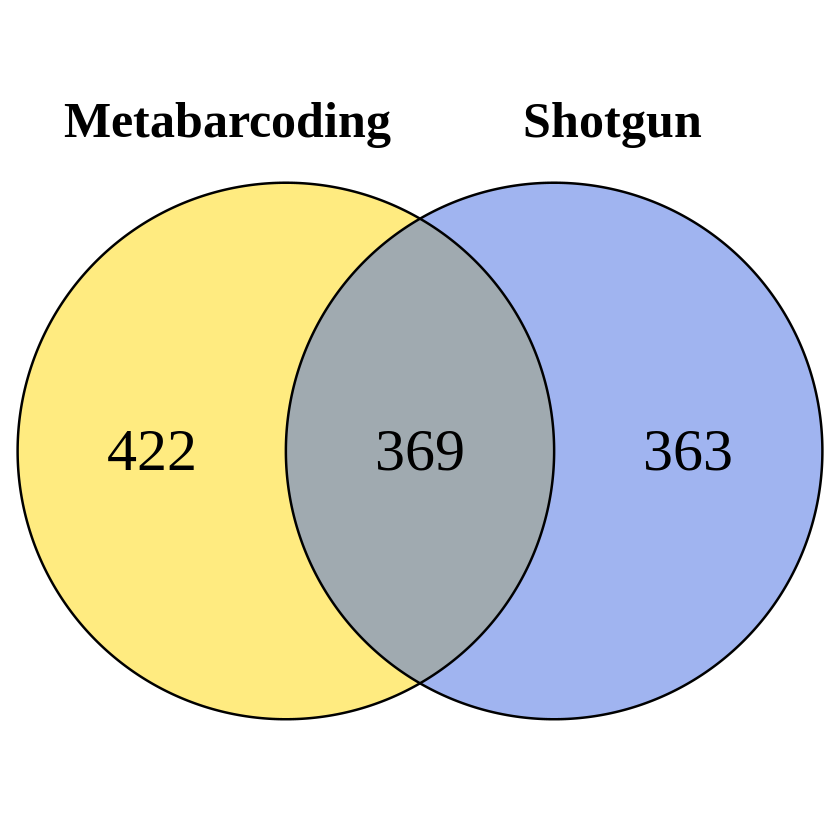

In [20]:
# Family
fam_metabar <- unique(metbar$family[!is.na(metbar$family)])
fam_shotgun <- unique(shotgun_eu$family[!is.na(shotgun_eu$family)])
taxa <- list(metabarcoding = fam_metabar, shotgun_eu = fam_shotgun)

# Venn Diagram (Saved manually)
display_venn(taxa,
             category.names = c("Metabarcoding", "Shotgun"),
             fill = c("gold", "royalblue"),
             cex = 3,
             cat.cex = 2.5, cat.fontface = "bold",
             cat.pos = c(-10,10),
             cat.dist = c(0.05, 0.05),
             scaled = F)

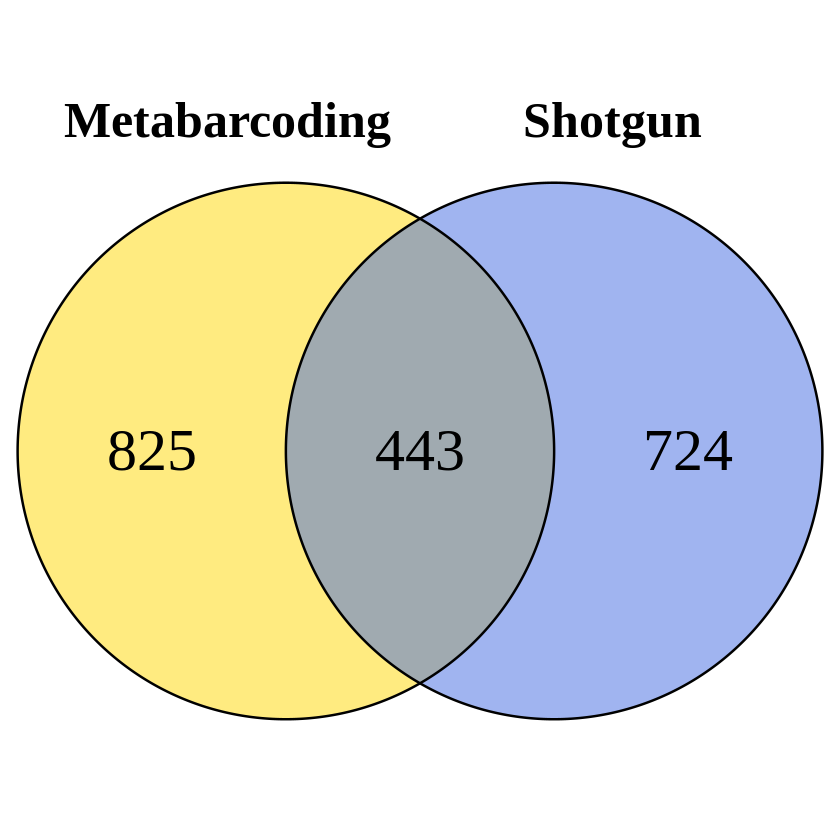

In [21]:
# Genus
gen_metabar <- unique(metbar$genus[!is.na(metbar$genus)])
gen_shotgun <- unique(shotgun_eu$genus[!is.na(shotgun_eu$genus)])
taxa <- list(metabarcoding = gen_metabar, shotgun_eu = gen_shotgun)

# Venn Diagram (Saved manually)
display_venn(taxa,
             category.names = c("Metabarcoding", "Shotgun"),
             fill = c("gold", "royalblue"),
             cex = 3,
             cat.cex = 2.5, cat.fontface = "bold",
             cat.pos = c(-10,10),
             cat.dist = c(0.05, 0.05),
             scaled = F)

In [23]:
# Phylum
phyl_metabar <- unique(metbar$phylum[!is.na(metbar$phylum)])
phyl_shotgun <- unique(shotgun_eu$phylum[!is.na(shotgun_eu$phylum)])
taxa <- list(metabarcoding = phyl_metabar, shotgun_eu = phyl_shotgun)

# Unique phyla
unq_metabar <- sort(taxa$metbar[!taxa$metbar %in% taxa$shotgun_eu])
unq_shotgun <- sort(taxa$shotgun_eu[!taxa$shotgun_eu %in% taxa$metbar])

# Phylum table
df <- data.frame(phylum = unique(c(phyl_metabar, phyl_shotgun)))

df <- df %>% mutate(meta = ifelse(df$phylum %in% phyl_metabar, "metabar", NA)) %>%
  mutate(shot = ifelse(df$phylum %in% phyl_shotgun, "shotgun", NA)) %>% 
  mutate(metabarcoding = ifelse(meta == "metabar", phylum, NA)) %>% 
  mutate(shotgun = ifelse(shot == "shotgun", phylum, NA)) %>% 
  select(metabarcoding, shotgun) %>% 
  arrange(shotgun)

# Presence absence table
rownames(df) <- ifelse(!is.na(df$metabarcoding), df$metabarcoding, df$shotgun )
df$metabarcoding <- ifelse(!is.na(df$metabarcoding), 1, 0)
df$shotgun <- ifelse(!is.na(df$shotgun), 1, 0)

# Recover phylum
df$phylum <- rownames(df)

# Order columns
df <- df[,c(3,1,2)]

# Share
df <- df %>% mutate(belonging = ifelse(metabarcoding == 1 & shotgun == 1, "shared",
                                 ifelse(metabarcoding == 1 & shotgun == 0, "metabarcoding","shotgun")))

write.table(df, "phylum_comparison_table.eukaryota.tsv", quote = F, row.names = F, sep="\t")

In [26]:
# Heatmap
dfm <- melt(df)
dfm$variable <- ifelse(dfm$variable == "shotgun", "Shotgun", "Metabarcoding")
dfm$variable <- factor(dfm$variable, levels = c("Shotgun","Metabarcoding"))
dfm$value <- ifelse(dfm$value == 0, "Absence", "Presence")
dfm$phylum <- factor(dfm$phylum, levels = rev(sort(unique(dfm$phylum))))
p <- dfm %>% ggplot() + geom_tile(aes(x=variable, y=phylum), fill="gray60", color="black", alpha=0.8) +
# Shotgun
geom_tile(data=subset(dfm, belonging == "shotgun" & variable == "Shotgun"),
          aes(x=variable, y=phylum), fill="royalblue", color="black") +
geom_tile(data=subset(dfm, belonging == "shotgun" & variable == "Metabarcoding"),
          aes(x=variable, y=phylum), fill="gray90", color="white") +
# Metabarcoding
geom_tile(data=subset(dfm, belonging == "metabarcoding" & variable == "Metabarcoding"),
          aes(x=variable, y=phylum), fill="gold", color="black") +
geom_tile(data=subset(dfm, belonging == "metabarcoding" & variable == "Shotgun"),
          aes(x=variable, y=phylum), fill="gray90", color="white") +
labs(x = "", y = "Phylum", fill="") +
theme_classic() %+replace% theme(axis.text.x = element_text(size=18),
                                 axis.text.y = element_text(size=11),
                                 axis.title = element_text(size=20),
                                 legend.title = element_text(size=18, face="bold"),
                                 legend.text = element_text(size=16))

png(file="comp.Presence_Absence.phylum.png", width=2300, height=2500, res=300)
p
dev.off()

Using phylum, belonging as id variables



png 
  2